In [467]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
random.seed(42)

%matplotlib inline

In [468]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [469]:
len(words)

32033

In [470]:
start_end_char = '.'

chars = sorted(list(set(''.join(words))))

# Create a mapping from character to index
stoi = {s:i+1 for i, s in enumerate(chars)}
# Add a start and end token
stoi[start_end_char] = 0

# Create a mapping from index to character
itos = {k:s for s, k in stoi.items()}
stoi, itos

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'})

In [471]:
# Building the dataset

# context length: how many characters to look at to predict the next one
block_size = 3

def dataset_builder(words):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * block_size
        for c in word + start_end_char:
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', c)
            context = context[1:] + [ix] # crop the first element and add the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X.shape, Y.shape)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X, Y = dataset_builder(words[:n1])
X_val, Y_val = dataset_builder(words[n1:n2])
X_test, Y_test = dataset_builder(words[n2:])

In [472]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([182778, 3]), torch.int64, torch.Size([182778]), torch.int64)

In [473]:
C = torch.randn((32, 2))
C

tensor([[ 0.6056,  0.8586],
        [ 0.0972,  1.5821],
        [ 0.3442,  0.5428],
        [-0.7313, -0.0545],
        [ 1.1797, -0.1506],
        [-1.2124,  1.1238],
        [-0.6847,  1.6247],
        [-0.1947, -0.1763],
        [-2.0014, -0.7183],
        [-0.7906, -0.6389],
        [-0.7081,  0.0312],
        [ 1.6376,  1.1415],
        [ 1.9917,  0.0836],
        [ 0.8805,  0.2055],
        [-2.0672, -0.0501],
        [ 1.6718,  0.0692],
        [-0.4251, -1.7796],
        [ 0.2988,  0.9776],
        [ 0.4600,  0.0345],
        [-0.6033,  0.5074],
        [-0.0417,  0.7663],
        [-1.8121, -0.4714],
        [-0.6577, -0.2468],
        [ 0.9766,  0.1729],
        [ 0.0090, -0.0789],
        [ 0.7654,  0.0972],
        [ 0.4611,  1.5361],
        [ 0.1605, -0.0200],
        [-0.2470,  0.2506],
        [-0.2002, -1.0400],
        [ 1.2391, -1.7022],
        [ 1.0936,  0.0094]])

In [474]:
emb = C[X].view(-1, 6)
emb.view(-1, 6).shape

torch.Size([182778, 6])

In [475]:
# For reproducibility
g = torch.Generator().manual_seed(2147483647)
dim = 200

# Initialize the parameters
C = torch.randn((27, 12), generator=g)

weights_dim = block_size * C.shape[1]

W1 = torch.randn((weights_dim, dim), generator=g)
b1 = torch.randn(dim, generator=g)

W2 = torch.randn((dim, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [476]:
sum(p.numel() for p in parameters)

13151

In [477]:
for p in parameters:
    p.requires_grad = True

In [478]:
emb = C[X].view(-1, weights_dim)

# Hidden layer with tanh activation
h = torch.tanh(emb @ W1 + b1)

logits = h @ W2 + b2

# We can replace the code bellow by the cross_entropy function
# Cross entropy can garantee the numerical stability
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)

# # Negative log likelihood
# loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()
# loss

loss = F.cross_entropy(logits, Y)
loss

tensor(25.7426, grad_fn=<NllLossBackward0>)

In [479]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [480]:
lri, lossi, stepi = [], [], []

In [481]:
def exp_lr_scheduler(step, lr=0.1):
    return lr * 0.9999899 ** (step)

round(exp_lr_scheduler(250000, 0.1), 10)

0.0080057292

In [482]:
lr = 0.1
start_decay_step = 150000

for i in range(300000):
    # Minibatch
    ix = torch.randint(0, X.shape[0], (64,))

    # Forward pass
    emb = C[X[ix]].view(-1, weights_dim)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    # lr = lrs[i]

    if i > start_decay_step:
        exp_lr_scheduler(i - start_decay_step, lr)
    else:
        lr = 0.1 if i < 50000 else 0.01
    
    # with torch.no_grad():
    for p in parameters:
        p.data += -lr * p.grad
    # track the learning rate and the loss
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.983199119567871


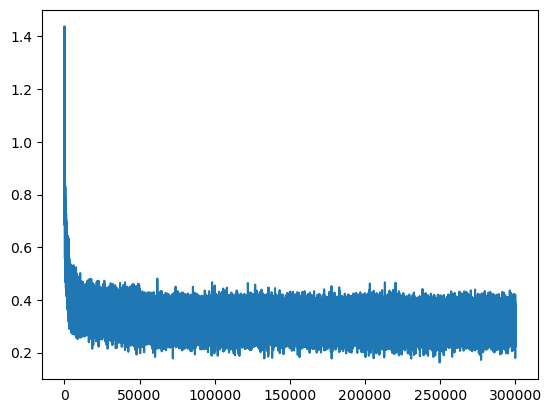

In [483]:
plt.plot(stepi, lossi)

In [484]:
emb = C[X_val].view(-1, weights_dim)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.3999, grad_fn=<NllLossBackward0>)

In [485]:
emb = C[X].view(-1, weights_dim)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.0824, grad_fn=<NllLossBackward0>)

In [486]:
# training split, dev-validation split, test split
# 80% / 10% / 10%

In [487]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join([itos[i] for i in out[:-1]]))

mona
kayanniee
med
rylle
emmastendra
grazeeydielie
shi
jen
eden
estanaraelyzios
kalin
shabergihamies
kinleeneverenteromiu
zey
dariyah
fael
yule
myskoura
hal
salynn
